In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [39]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [40]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [41]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [42]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [43]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [44]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [45]:
input_size = 784
output_size = 10

In [46]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
#         self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
#     def _shuffle_data_(self):
#         randidx = random.sample(range(len(self.data)), k=len(self.data))
# #         self.data = self.data[randidx]
# #         self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [47]:
class Subset_Dataset(data.Dataset):
    
    def __init__(self, dataset, index):
        self.dataset = dataset
        self.index = index
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        idx = self.index[idx]
        img, lbl = self.dataset[idx]
        return img, lbl

In [48]:
## The classifiers store all the data in INDEX FORM

In [49]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [50]:
train_dataset[[0,1,2]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0]))

In [51]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 2.
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers, p=1)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
#             x = self._normalize_negative_dist_(-dists*1e5, dim=1)
#             x = self._normalize_inverse_dist_(dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
#             x = self._normalize_negative_dist_(-dists*self.inv_temp, dim=1)
#             x = self._normalize_inverse_dist_(dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
    
    def _normalize_negative_dist_(self, neg_dists, dim=1):
        #### just normalize
        neg_dists = torch.exp(neg_dists)
        return neg_dists/torch.sum(neg_dists, dim=dim, keepdim=True) 

    def _normalize_inverse_dist_(self, dists, dim=1):
        #### inverse the distances and normalize
        inv_dist = torch.clamp(1/dists, 1e-7, 1e7)
        weight = inv_dist/inv_dist.sum(dim=dim, keepdim=True)
        return weight

In [52]:
# torch.clamp(torch.Tensor([1])/0, -10, 10)

In [53]:
class ClassifierTree:
    
    def __init__(self, train_data, test_data, device):
        self.root = LocalClassifier(device)
        self.root.create_network_0(784, [784], 10, 10)
        
        self.train_data = train_data
        self.test_data = test_data
        self.device = device
        pass
    
    def display_stats(self):
        indexing = "0"
        self.root.display_stats(indexing)
        acc, tot = self.root.get_correct_train()
        train_acc = acc/tot
        acc, tot = self.root.get_correct_test()
        test_acc = acc/tot
        print(f"Final Accuracy is Train: {train_acc :.5f} Test: {test_acc :.5f}")
            
    def get_parent_node(self, index_list:list):
        parent = self.root
        index_list = index_list[1:]
        for idx in index_list[:-1]:
            parent = parent.children[idx]
        return parent
    
    def get_node(self, index_list:list):
        parent = self.root
        index_list = index_list[1:]
        for idx in index_list[:-1]:
            parent = parent.children[idx]
        child = parent.children[index_list[-1]]
        return child
    
    
    def get_all_child_index(self):
        child_list = []
        self.root.get_all_index([0], child_list)
        return child_list

In [54]:
class LeafNode:
    def __init__(self):
        self.pred = None
        self.classes = None
        self.num_correct = None
        self.train_indices = None
        self.test_indices = None
        self.test_correct = None
        
    def display_stats(self, indexing):
        print(f"[{indexing}] : Train -> {self.num_correct/len(self.train_indices) :.4f}", end=" ")
        
        if len(self.test_indices)>0:
            test_acc = self.test_correct/len(self.test_indices)
        else:
            test_acc = -1
        print(f"Test -> {test_acc :.4f}, NUM: {len(self.train_indices)}, classes: {self.pred}:{self.classes}")

    def get_correct_train(self):
        return self.num_correct, len(self.train_indices)
    
    def get_correct_test(self):
        return self.test_correct, len(self.test_indices)
    
    def get_all_index(self, indexing, indx_lst):
        indx_lst.append(indexing)
                
        
    

class LocalClassifier:
    
    def __init__(self, device):
        self.model = None
        self.classifier = None
        self.device = device
        
        ### for training purposes
        self.train_loader = None
        self.test_loader = None
        self.optimizer = None
        self.frozen = False
        self.criterion = None
        
        ### after freazing the model, record stats
        self.children = []
    
    def create_network_0(self, input_dim, hidden_dims:list, output_dims, num_classifiers):
        actf = irf.Swish
        flows = []
        flows.append(ActNorm(input_dim))
#         for i in range(len(hidden_dims)):
#             if isinstance(hidden_dims[i], list):
#                 hdi = hidden_dims[i]
#             else:
#                 hdi = [hidden_dims[i]]
#             flows.append(irf.ResidualFlow(input_dim, hdi, activation=actf))
# #             flows.append(ActNorm(input_dim))

        flows.append(LinearFlow(784))
        
        invertible = SequentialFlow(flows)
        self.model = invertible.to(device)
        
        classifier = ConnectedClassifier_SoftKMeans(784, num_classifiers, output_dims)
        self.classifier = classifier.to(device)
        
    def create_train_loader_1(self, train_dataset, index, batch_size):
        dataset = Subset_Dataset(train_dataset, index)
        print(f"Train Dataset Num: {len(index)}")
        self.train_loader = data.DataLoader(dataset=dataset,
                                            num_workers=4, 
                                            batch_size=batch_size, 
                                            shuffle=True)
    
    def create_test_loader_2(self, test_dataset, index, batch_size):
        dataset = Subset_Dataset(test_dataset, index)
        print(f"Test Dataset Num: {len(index)}")
        self.test_loader = data.DataLoader(dataset=dataset,
                                            num_workers=4, 
                                            batch_size=batch_size, 
                                            shuffle=False)
        
    def create_optimizer_3(self, lr):
        self.optimizer = optim.Adam(list(self.model.parameters())+list(self.classifier.parameters()), 
                                    lr=lr, weight_decay=1e-15)
        self.criterion = nn.CrossEntropyLoss()
        
        
    def train_classifier_4(self, epochs, ):
        if self.frozen:
            raise ValueError("This classifier is frozen. Training it might cause errors in childern classifiers")
            
    ############# TRAINING FUNCTIONALITY BELOW ####################    

        index = 0
        train_accs, test_accs = [], []
        for epoch in tqdm(list(range(epochs))):
            train_acc = 0
            train_count = 0
            for xx, yy in self.train_loader:
                xx, yy = xx.to(device), yy.to(device)
#                 print(xx)
                yout = self.model(xx)
#                 print(yout, torch.count_nonzero(torch.isnan(yout)))
                yout = self.classifier(yout)    
#                 print(yout, torch.count_nonzero(torch.isnan(yout)))
                loss = self.criterion(yout, yy)
#                 print(loss)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
#                 losses.append(float(loss))

                outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                train_acc += correct
                train_count += len(outputs)

            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0

            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
            test_count = 0
            test_acc = 0
            for xx, yy in self.test_loader:
                xx, yy = xx.to(device), yy.to(device)
                with torch.no_grad():
                    yout = self.classifier(self.model(xx))    
                outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print()

        ### after each class index is finished training
        print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')
        
        
    def freeze_and_compute_stats_5(self, MIN_POINTS):
        assert MIN_POINTS > 0
        if self.frozen:
            raise ValueError("This classifier is frozen. The stat has already been calculated")
            
        self.frozen = True
        
        ### delete optimizer, frees memory
        del self.optimizer
        ### take classifier to eval mode
        self.model.eval()
        self.classifier.eval()
        
        with torch.no_grad():
            #### remove classifier with no data or few data.

            set_count = torch.zeros(self.classifier.num_sets).to(device)
            for xx, yy in self.train_loader:
                xx, yy = xx.to(device), yy.to(device)
                with torch.no_grad():
                    yout = self.classifier(self.model(xx), hard=True)

                cls_indx = torch.argmax(self.classifier.cls_confidence, dim=1)
                set_indx, count = torch.unique(cls_indx, return_counts=True) 
                set_count[set_indx] += count

            #### find only the classifier having some data
            classifier_index = []
            classifier_count = []

            for i, cnt in enumerate(set_count.type(torch.long).tolist()):
    #             if cnt == 0: continue
                if cnt < MIN_POINTS: continue

                classifier_index.append(i)
                classifier_count.append(int(cnt))

            #### remove the classifier representing no data
            #### OR representing data less than given N
            print(f"Keeping only N={len(classifier_index)}/{len(self.classifier.centers)} classifiers.")
            self.classifier.centers.data = self.classifier.centers.data[classifier_index]
            self.classifier.cls_weight.data = self.classifier.cls_weight.data[classifier_index]
            ### removed

            ###### compute stats now, from pruned tree.
            def get_Cs_Os_Ts_Zs(data_loader):
                Cs = [] ## winning classifier
                Os = [] ## output of winning classifier
                Ts = [] ## target class
                Zs = []

                for xx, yy in data_loader:
                    Ts.append(yy)
                    xx, yy = xx.to(device), yy.to(device)
                    with torch.no_grad():
                        zz = self.model(xx)
                        Zs.append(zz.data.cpu())
                        yout = self.classifier(zz, hard=True)
                        Os.append(torch.argmax(yout, dim=1).data.cpu())

                    cls_indx = torch.argmax(self.classifier.cls_confidence, dim=1)
                    Cs.append(cls_indx)

                Cs = torch.cat(Cs, dim=0)
                Ts = torch.cat(Ts, dim=0)
                Os = torch.cat(Os, dim=0)
                Zs = torch.cat(Zs, dim=0)
                return Cs, Ts, Os, Zs


            unshuffled_data = data.DataLoader(dataset=self.train_loader.dataset,
                                                num_workers=4, 
                                                batch_size=self.train_loader.batch_size, 
                                                shuffle=False)
            Cs, Ts, Os, Zs = get_Cs_Os_Ts_Zs(unshuffled_data)
            _Cs, _Ts, _, _Zs = get_Cs_Os_Ts_Zs(self.test_loader)

            print("Hard inference on the data !")
            self.children = []
            acc = 0
            for cls_idx in range(len(self.classifier.centers)):
                data_idx = torch.nonzero(Cs == cls_idx)
                Ti = Ts[data_idx]

                ### get prediction according to data
                cls, count = torch.unique(Ti, return_counts=True, sorted=True)
                pred = cls[torch.argmax(count)]
                p = (Ti==pred).type(torch.float32).sum()
                acc += p

                child = LeafNode()
                child.pred = int(pred)
                child.classes = cls.tolist()
                child.num_correct = int(p)
                child.train_indices = data_idx.cpu().reshape(-1)
                
                test_idx = torch.nonzero(_Cs == cls_idx)
                test_p = (_Ts[test_idx]==pred).type(torch.float32).sum()
                child.test_indices = test_idx.cpu().reshape(-1)
                child.test_correct = int(test_p)

                self.children.append(child)

                print(f"idx: {cls_idx}\tout: {int(pred)} \t acc: {p/len(Ti)*100 :.3f} \tclasses:{cls.tolist()}")

            print(f"Accuracy: {float(acc)/len(Ts)}")
        return Zs, Ts, _Zs, _Ts
        
        
    def display_stats(self, indexing):
        for i, c in enumerate(self.children):
            c.display_stats(indexing+f", {i}")
            
    def get_all_index(self, indexing:list, indx_lst):
        for i, c in enumerate(self.children):
            c.get_all_index(indexing+[i], indx_lst)
        pass

    def get_correct_train(self):
        a, b = 0, 0
        for i, c in enumerate(self.children):
            _a, _b = c.get_correct_train()
            a+= _a
            b+= _b
        return a, b
    
    def get_correct_test(self):
        a, b = 0, 0
        for i, c in enumerate(self.children):
            _a, _b = c.get_correct_test()
            a+= _a
            b+= _b
        return a, b
        
    def inference_forward(self, x):
        with torch.no_grad():
            zz = self.model(x)
            yout = self.classifier(zz, hard=True)
            return torch.argmax(classifier.cls_confidence, dim=1)

In [55]:
tree = ClassifierTree(train_dataset, test_dataset, device)

In [56]:
tree.root.create_network_0(784, [784], 10, 10)

In [57]:
tree.root.create_train_loader_1(train_dataset, 
                                torch.arange(0, len(train_dataset), dtype=torch.long), 
                                50)

Train Dataset Num: 60000


In [58]:
tree.root.create_test_loader_2(test_dataset, 
                               torch.arange(0, len(test_dataset), dtype=torch.long), 
                               50)

Test Dataset Num: 10000


In [59]:
tree.root.create_optimizer_3(lr=0.0003)

In [60]:
# list(tree.root.classifier.parameters())

In [61]:
# tree.root.model(torch.randn(10, 784).to(device))

In [62]:
tree.root.train_classifier_4(30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:1.6281981468200684


  3%|▎         | 1/30 [00:02<01:17,  2.68s/it]

Train Acc:83.21%, Test Acc:84.80%

Epoch: 1:0,  Loss:1.5919349193572998


  7%|▋         | 2/30 [00:05<01:15,  2.68s/it]

Train Acc:86.91%, Test Acc:85.62%

Epoch: 2:0,  Loss:1.5994397401809692


 10%|█         | 3/30 [00:08<01:12,  2.68s/it]

Train Acc:87.98%, Test Acc:85.78%

Epoch: 3:0,  Loss:1.6932319402694702


 13%|█▎        | 4/30 [00:10<01:09,  2.67s/it]

Train Acc:88.81%, Test Acc:86.60%

Epoch: 4:0,  Loss:1.574293613433838


 17%|█▋        | 5/30 [00:13<01:06,  2.65s/it]

Train Acc:89.32%, Test Acc:86.60%

Epoch: 5:0,  Loss:1.6384066343307495


 20%|██        | 6/30 [00:15<01:03,  2.66s/it]

Train Acc:89.97%, Test Acc:87.22%

Epoch: 6:0,  Loss:1.6159193515777588


 23%|██▎       | 7/30 [00:18<01:01,  2.67s/it]

Train Acc:90.42%, Test Acc:87.44%

Epoch: 7:0,  Loss:1.5327304601669312


 27%|██▋       | 8/30 [00:21<00:59,  2.69s/it]

Train Acc:90.91%, Test Acc:87.10%

Epoch: 8:0,  Loss:1.5932506322860718


 30%|███       | 9/30 [00:24<00:56,  2.67s/it]

Train Acc:91.31%, Test Acc:87.65%

Epoch: 9:0,  Loss:1.5675780773162842


 33%|███▎      | 10/30 [00:26<00:53,  2.67s/it]

Train Acc:91.52%, Test Acc:87.57%

Epoch: 10:0,  Loss:1.5709599256515503


 37%|███▋      | 11/30 [00:29<00:50,  2.67s/it]

Train Acc:91.91%, Test Acc:87.91%

Epoch: 11:0,  Loss:1.6376208066940308


 40%|████      | 12/30 [00:32<00:47,  2.67s/it]

Train Acc:92.04%, Test Acc:87.76%

Epoch: 12:0,  Loss:1.5779662132263184


 43%|████▎     | 13/30 [00:34<00:45,  2.68s/it]

Train Acc:92.31%, Test Acc:88.21%

Epoch: 13:0,  Loss:1.5978606939315796


 47%|████▋     | 14/30 [00:37<00:42,  2.68s/it]

Train Acc:92.63%, Test Acc:88.13%

Epoch: 14:0,  Loss:1.4955466985702515


 50%|█████     | 15/30 [00:40<00:40,  2.67s/it]

Train Acc:92.71%, Test Acc:87.92%

Epoch: 15:0,  Loss:1.5890904664993286


 53%|█████▎    | 16/30 [00:42<00:37,  2.67s/it]

Train Acc:92.91%, Test Acc:88.00%

Epoch: 16:0,  Loss:1.5102380514144897


 57%|█████▋    | 17/30 [00:45<00:34,  2.69s/it]

Train Acc:93.07%, Test Acc:88.23%

Epoch: 17:0,  Loss:1.518369197845459


 60%|██████    | 18/30 [00:48<00:32,  2.70s/it]

Train Acc:93.12%, Test Acc:88.06%

Epoch: 18:0,  Loss:1.5521773099899292


 63%|██████▎   | 19/30 [00:50<00:29,  2.70s/it]

Train Acc:93.29%, Test Acc:88.20%

Epoch: 19:0,  Loss:1.4967044591903687


 67%|██████▋   | 20/30 [00:53<00:26,  2.68s/it]

Train Acc:93.46%, Test Acc:87.72%

Epoch: 20:0,  Loss:1.5355665683746338


 70%|███████   | 21/30 [00:56<00:24,  2.68s/it]

Train Acc:93.55%, Test Acc:88.04%

Epoch: 21:0,  Loss:1.5410256385803223


 73%|███████▎  | 22/30 [00:58<00:21,  2.69s/it]

Train Acc:93.54%, Test Acc:88.11%

Epoch: 22:0,  Loss:1.5675630569458008


 77%|███████▋  | 23/30 [01:01<00:18,  2.69s/it]

Train Acc:93.66%, Test Acc:88.14%

Epoch: 23:0,  Loss:1.5476497411727905


 80%|████████  | 24/30 [01:04<00:15,  2.66s/it]

Train Acc:93.82%, Test Acc:87.96%

Epoch: 24:0,  Loss:1.5002377033233643


 83%|████████▎ | 25/30 [01:06<00:13,  2.67s/it]

Train Acc:93.88%, Test Acc:88.09%

Epoch: 25:0,  Loss:1.5040040016174316


 87%|████████▋ | 26/30 [01:09<00:10,  2.68s/it]

Train Acc:93.95%, Test Acc:88.44%

Epoch: 26:0,  Loss:1.5122250318527222


 90%|█████████ | 27/30 [01:12<00:08,  2.68s/it]

Train Acc:94.06%, Test Acc:88.39%

Epoch: 27:0,  Loss:1.5112838745117188


 93%|█████████▎| 28/30 [01:15<00:05,  2.70s/it]

Train Acc:94.11%, Test Acc:88.19%

Epoch: 28:0,  Loss:1.5558323860168457


 97%|█████████▋| 29/30 [01:17<00:02,  2.71s/it]

Train Acc:94.19%, Test Acc:88.10%

Epoch: 29:0,  Loss:1.464711308479309


100%|██████████| 30/30 [01:20<00:00,  2.68s/it]

Train Acc:94.28%, Test Acc:88.10%

	-> MAX Train Acc 94.27666666666667 ; Test Acc 88.44


In [25]:
# asdfsdfasdf

In [26]:
# torch.isinf(tree.root.model.flows[0].s)

In [63]:
nX, nT, _nX, _nT = tree.root.freeze_and_compute_stats_5(MIN_POINTS=5)

Keeping only N=10/10 classifiers.
Hard inference on the data !
idx: 0	out: 0 	 acc: 89.610 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 1	out: 1 	 acc: 99.194 	classes:[0, 1, 2, 3, 4, 6, 7, 8, 9]
idx: 2	out: 2 	 acc: 89.094 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 3	out: 3 	 acc: 93.656 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 4	out: 4 	 acc: 89.734 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 5	out: 5 	 acc: 98.917 	classes:[0, 2, 5, 6, 7, 8, 9]
idx: 6	out: 6 	 acc: 88.376 	classes:[0, 1, 2, 3, 4, 5, 6, 8]
idx: 7	out: 7 	 acc: 98.156 	classes:[2, 4, 5, 6, 7, 8, 9]
idx: 8	out: 8 	 acc: 97.322 	classes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
idx: 9	out: 9 	 acc: 98.326 	classes:[0, 3, 5, 6, 7, 8, 9]
Accuracy: 0.9426


In [64]:
tree.display_stats()

[0, 0] : Train -> 0.8961 Test -> 0.8057, NUM: 6179, classes: 0:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 1] : Train -> 0.9919 Test -> 0.9807, NUM: 5955, classes: 1:[0, 1, 2, 3, 4, 6, 7, 8, 9]
[0, 2] : Train -> 0.8909 Test -> 0.7963, NUM: 6079, classes: 2:[0, 1, 2, 3, 4, 6, 8]
[0, 3] : Train -> 0.9366 Test -> 0.8762, NUM: 6148, classes: 3:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 4] : Train -> 0.8973 Test -> 0.7981, NUM: 6166, classes: 4:[0, 1, 2, 3, 4, 6, 8]
[0, 5] : Train -> 0.9892 Test -> 0.9539, NUM: 6003, classes: 5:[0, 2, 5, 6, 7, 8, 9]
[0, 6] : Train -> 0.8838 Test -> 0.7232, NUM: 5420, classes: 6:[0, 1, 2, 3, 4, 5, 6, 8]
[0, 7] : Train -> 0.9816 Test -> 0.9526, NUM: 5966, classes: 7:[2, 4, 5, 6, 7, 8, 9]
[0, 8] : Train -> 0.9732 Test -> 0.9613, NUM: 6049, classes: 8:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 9] : Train -> 0.9833 Test -> 0.9507, NUM: 6035, classes: 9:[0, 3, 5, 6, 7, 8, 9]
Final Accuracy is Train: 0.94260 Test: 0.88100


In [65]:
node = tree.get_node([0, 0])

In [66]:
len(node.train_indices)

6179

In [67]:
tree.get_all_child_index()

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9]]

In [68]:
_train_data = train_data.clone()
_test_data = test_data.clone()

## Distance based analysis of transformed X

In [69]:
indx = [0,0]
parent = tree.get_parent_node(indx)
node = tree.get_node(indx)

In [70]:
_train_data[node.train_indices] = nX[node.train_indices]
_test_data[node.test_indices] = _nX[node.test_indices]

In [71]:
Zi = nX[node.train_indices]
Ti = nT[node.train_indices]

In [72]:
center = parent.classifier.centers[indx[-1]].data

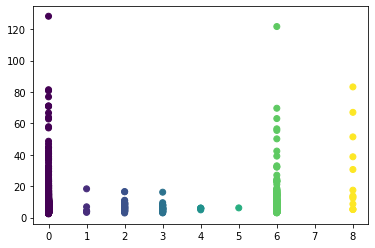

In [74]:
## distance from the center and corresponding class
dists = torch.norm(Zi-center.cpu().data.unsqueeze(0), p=1, dim=1)/784 #np.sqrt(784)
plt.scatter(Ti, dists, c=Ti)

In [75]:
### mean, std dist of each class
for i in range(10):
    _ind = torch.nonzero(Ti==i)
    if len(_ind) < 1: continue
    _dat = dists[_ind]
    print(f"class: {i}, mean: {_dat.mean()}, std:{_dat.std()}")

class: 0, mean: 6.541017532348633, std:4.818256855010986
class: 1, mean: 6.79149055480957, std:5.782317161560059
class: 2, mean: 7.118994235992432, std:2.8029868602752686
class: 3, mean: 5.909376621246338, std:2.3564529418945312
class: 4, mean: 5.745668888092041, std:0.4199015200138092
class: 5, mean: 6.190677165985107, std:nan
class: 6, mean: 8.154555320739746, std:8.35658073425293
class: 8, mean: 27.100351333618164, std:25.710935592651367


In [39]:
asdfsadf

NameError: name 'asdfsadf' is not defined

### Select a node and train a new classifier: from transformed data

In [76]:
### make selecting index automatic
###### for all child index analyse how much incorrect training examples are present

### 1. train the cild with maximum incorrect ones.
### 2. train the network for at least 30,000 steps:
###     for a 5K dataset with 50 batch size, 100 steps in one epoch, so train for 300 epochs

MIN_POINTS = 10
batch_size = 50

max_incorrect = 0
max_inc_node = None
train_epoch = None
for ci in tree.get_all_child_index():
    node = tree.get_node(ci)
    num_data = len(node.train_indices)
    if num_data < MIN_POINTS: continue
        
    incorrect = num_data - node.num_correct
    if incorrect > max_incorrect:
        max_incorrect = incorrect
        max_inc_node = ci
        steps_in_epoch = max(num_data/batch_size, 1)
        train_epoch = int(30000/steps_in_epoch)
        
print(f"Max incorrect: {max_incorrect}, {max_inc_node}, train for: {train_epoch}")

Max incorrect: 663, [0, 2], train for: 246


In [77]:
###### for a given index of classifier make it 
# indx = [0, 0]
indx = max_inc_node
parent = tree.get_parent_node(indx)
node = tree.get_node(indx)

In [78]:
# node.train_indices, node.test_indices
node.pred, node.classes

(2, [0, 1, 2, 3, 4, 6, 8])

In [79]:
alt_node = LocalClassifier(device)

In [80]:
# train_dataset.data = _train_data
# test_dataset.data = _test_data
# train_dataset.data = train_data
# test_dataset.data = test_data

In [81]:
### make classifier with only available classes
avl_cls = node.classes
num_cls = len(node.classes)
output_dim = 10
num_sets = num_cls*2
init_val = torch.abs(torch.randn(num_sets, output_dim)*0.01)
for ns in range(num_sets):
    init_val[ns, avl_cls[ns%num_cls]] = 2.

alt_node.create_network_0(784, [1], output_dim, num_sets)
alt_node.classifier.cls_weight.data = init_val.to(device)

alt_node.create_train_loader_1(train_dataset, node.train_indices, batch_size=50)
alt_node.create_test_loader_2(test_dataset, node.test_indices, batch_size=50)
alt_node.create_optimizer_3(lr=0.0003)

Train Dataset Num: 6079
Test Dataset Num: 1036


In [82]:
node.display_stats("")

[] : Train -> 0.8909 Test -> 0.7963, NUM: 6079, classes: 2:[0, 1, 2, 3, 4, 6, 8]


In [83]:
alt_node.train_classifier_4(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:1.5298504829406738


  1%|          | 1/100 [00:00<00:45,  2.17it/s]

Train Acc:87.04%, Test Acc:79.63%

Epoch: 1:0,  Loss:1.5298537015914917


  2%|▏         | 2/100 [00:00<00:45,  2.15it/s]

Train Acc:89.11%, Test Acc:79.63%

Epoch: 2:0,  Loss:1.5642292499542236


  3%|▎         | 3/100 [00:01<00:45,  2.14it/s]

Train Acc:89.16%, Test Acc:79.63%

Epoch: 3:0,  Loss:1.529465675354004


  4%|▍         | 4/100 [00:01<00:44,  2.15it/s]

Train Acc:89.27%, Test Acc:79.63%

Epoch: 4:0,  Loss:1.59866464138031


  5%|▌         | 5/100 [00:02<00:44,  2.14it/s]

Train Acc:89.31%, Test Acc:79.63%

Epoch: 5:0,  Loss:1.4945975542068481


  6%|▌         | 6/100 [00:02<00:44,  2.13it/s]

Train Acc:89.36%, Test Acc:79.63%

Epoch: 6:0,  Loss:1.631954312324524


  7%|▋         | 7/100 [00:03<00:43,  2.14it/s]

Train Acc:89.34%, Test Acc:79.63%

Epoch: 7:0,  Loss:1.4945437908172607


  8%|▊         | 8/100 [00:03<00:43,  2.14it/s]

Train Acc:89.41%, Test Acc:79.63%

Epoch: 8:0,  Loss:1.5640060901641846


  9%|▉         | 9/100 [00:04<00:42,  2.13it/s]

Train Acc:89.47%, Test Acc:79.63%

Epoch: 9:0,  Loss:1.5995876789093018


 10%|█         | 10/100 [00:04<00:42,  2.13it/s]

Train Acc:89.54%, Test Acc:79.63%

Epoch: 10:0,  Loss:1.4946309328079224


 11%|█         | 11/100 [00:05<00:41,  2.13it/s]

Train Acc:89.64%, Test Acc:79.63%

Epoch: 11:0,  Loss:1.5699102878570557


 12%|█▏        | 12/100 [00:05<00:41,  2.14it/s]

Train Acc:89.72%, Test Acc:79.63%

Epoch: 12:0,  Loss:1.495468258857727


 13%|█▎        | 13/100 [00:06<00:40,  2.15it/s]

Train Acc:89.75%, Test Acc:79.73%

Epoch: 13:0,  Loss:1.5993950366973877


 14%|█▍        | 14/100 [00:06<00:39,  2.16it/s]

Train Acc:89.82%, Test Acc:79.63%

Epoch: 14:0,  Loss:1.5617035627365112


 15%|█▌        | 15/100 [00:06<00:39,  2.17it/s]

Train Acc:89.82%, Test Acc:79.73%

Epoch: 15:0,  Loss:1.5635322332382202


 16%|█▌        | 16/100 [00:07<00:38,  2.18it/s]

Train Acc:89.88%, Test Acc:79.73%

Epoch: 16:0,  Loss:1.632506012916565


 17%|█▋        | 17/100 [00:07<00:38,  2.18it/s]

Train Acc:89.92%, Test Acc:79.73%

Epoch: 17:0,  Loss:1.4954824447631836


 18%|█▊        | 18/100 [00:08<00:37,  2.17it/s]

Train Acc:89.93%, Test Acc:79.73%

Epoch: 18:0,  Loss:1.5981481075286865


 19%|█▉        | 19/100 [00:08<00:37,  2.17it/s]

Train Acc:89.95%, Test Acc:79.73%

Epoch: 19:0,  Loss:1.4597315788269043


 20%|██        | 20/100 [00:09<00:36,  2.17it/s]

Train Acc:90.01%, Test Acc:79.73%

Epoch: 20:0,  Loss:1.5287957191467285


 21%|██        | 21/100 [00:09<00:36,  2.17it/s]

Train Acc:90.00%, Test Acc:79.73%

Epoch: 21:0,  Loss:1.5288063287734985


 22%|██▏       | 22/100 [00:10<00:35,  2.17it/s]

Train Acc:90.05%, Test Acc:79.63%

Epoch: 22:0,  Loss:1.4943509101867676


 23%|██▎       | 23/100 [00:10<00:35,  2.16it/s]

Train Acc:90.06%, Test Acc:79.73%

Epoch: 23:0,  Loss:1.563367486000061


 24%|██▍       | 24/100 [00:11<00:35,  2.15it/s]

Train Acc:90.08%, Test Acc:79.83%

Epoch: 24:0,  Loss:1.4942941665649414


 25%|██▌       | 25/100 [00:11<00:34,  2.15it/s]

Train Acc:90.13%, Test Acc:79.63%

Epoch: 25:0,  Loss:1.598175048828125


 26%|██▌       | 26/100 [00:12<00:34,  2.15it/s]

Train Acc:90.15%, Test Acc:79.83%

Epoch: 26:0,  Loss:1.598057746887207


 27%|██▋       | 27/100 [00:12<00:33,  2.16it/s]

Train Acc:90.15%, Test Acc:79.73%

Epoch: 27:0,  Loss:1.5635957717895508


 28%|██▊       | 28/100 [00:13<00:33,  2.14it/s]

Train Acc:90.16%, Test Acc:79.63%

Epoch: 28:0,  Loss:1.459950566291809


 29%|██▉       | 29/100 [00:13<00:33,  2.13it/s]

Train Acc:90.18%, Test Acc:79.73%

Epoch: 29:0,  Loss:1.5981717109680176


 30%|███       | 30/100 [00:13<00:33,  2.10it/s]

Train Acc:90.21%, Test Acc:79.73%

Epoch: 30:0,  Loss:1.6030070781707764


 31%|███       | 31/100 [00:14<00:32,  2.10it/s]

Train Acc:90.25%, Test Acc:79.83%

Epoch: 31:0,  Loss:1.5686981678009033


 32%|███▏      | 32/100 [00:14<00:32,  2.12it/s]

Train Acc:90.28%, Test Acc:79.83%

Epoch: 32:0,  Loss:1.538856029510498


 33%|███▎      | 33/100 [00:15<00:31,  2.11it/s]

Train Acc:90.34%, Test Acc:79.83%

Epoch: 33:0,  Loss:1.564042329788208


 34%|███▍      | 34/100 [00:15<00:30,  2.13it/s]

Train Acc:90.43%, Test Acc:80.02%

Epoch: 34:0,  Loss:1.4948999881744385


 35%|███▌      | 35/100 [00:16<00:30,  2.14it/s]

Train Acc:90.46%, Test Acc:79.63%

Epoch: 35:0,  Loss:1.5635790824890137


 36%|███▌      | 36/100 [00:16<00:29,  2.14it/s]

Train Acc:90.46%, Test Acc:79.73%

Epoch: 36:0,  Loss:1.5983357429504395


 37%|███▋      | 37/100 [00:17<00:29,  2.15it/s]

Train Acc:90.51%, Test Acc:79.83%

Epoch: 37:0,  Loss:1.5981898307800293


 38%|███▊      | 38/100 [00:17<00:28,  2.15it/s]

Train Acc:90.52%, Test Acc:79.73%

Epoch: 38:0,  Loss:1.5303162336349487


 39%|███▉      | 39/100 [00:18<00:28,  2.16it/s]

Train Acc:90.57%, Test Acc:79.92%

Epoch: 39:0,  Loss:1.5303115844726562


 40%|████      | 40/100 [00:18<00:27,  2.17it/s]

Train Acc:90.62%, Test Acc:79.83%

Epoch: 40:0,  Loss:1.6325057744979858


 41%|████      | 41/100 [00:19<00:27,  2.15it/s]

Train Acc:90.66%, Test Acc:79.73%

Epoch: 41:0,  Loss:1.4951022863388062


 42%|████▏     | 42/100 [00:19<00:26,  2.17it/s]

Train Acc:90.77%, Test Acc:79.73%

Epoch: 42:0,  Loss:1.529067039489746


 43%|████▎     | 43/100 [00:20<00:26,  2.16it/s]

Train Acc:90.77%, Test Acc:79.63%

Epoch: 43:0,  Loss:1.494343638420105


 44%|████▍     | 44/100 [00:20<00:26,  2.15it/s]

Train Acc:90.80%, Test Acc:79.83%

Epoch: 44:0,  Loss:1.5979444980621338


 45%|████▌     | 45/100 [00:20<00:25,  2.14it/s]

Train Acc:90.84%, Test Acc:79.92%

Epoch: 45:0,  Loss:1.5608885288238525


 46%|████▌     | 46/100 [00:21<00:25,  2.15it/s]

Train Acc:90.92%, Test Acc:79.63%

Epoch: 46:0,  Loss:1.5980616807937622


 47%|████▋     | 47/100 [00:21<00:24,  2.15it/s]

Train Acc:90.94%, Test Acc:79.73%

Epoch: 47:0,  Loss:1.5292729139328003


 48%|████▊     | 48/100 [00:22<00:24,  2.15it/s]

Train Acc:90.97%, Test Acc:79.63%

Epoch: 48:0,  Loss:1.529570460319519


 49%|████▉     | 49/100 [00:22<00:23,  2.15it/s]

Train Acc:90.95%, Test Acc:79.73%

Epoch: 49:0,  Loss:1.5289233922958374


 50%|█████     | 50/100 [00:23<00:23,  2.15it/s]

Train Acc:90.99%, Test Acc:79.63%

Epoch: 50:0,  Loss:1.494339108467102


 51%|█████     | 51/100 [00:23<00:22,  2.15it/s]

Train Acc:91.00%, Test Acc:79.63%

Epoch: 51:0,  Loss:1.4942917823791504


 52%|█████▏    | 52/100 [00:24<00:22,  2.15it/s]

Train Acc:91.00%, Test Acc:79.54%

Epoch: 52:0,  Loss:1.529418706893921


 53%|█████▎    | 53/100 [00:24<00:22,  2.14it/s]

Train Acc:91.05%, Test Acc:79.54%

Epoch: 53:0,  Loss:1.5272467136383057


 54%|█████▍    | 54/100 [00:25<00:21,  2.14it/s]

Train Acc:91.08%, Test Acc:79.73%

Epoch: 54:0,  Loss:1.5364103317260742


 55%|█████▌    | 55/100 [00:25<00:21,  2.13it/s]

Train Acc:91.13%, Test Acc:79.54%

Epoch: 55:0,  Loss:1.5284416675567627


 56%|█████▌    | 56/100 [00:26<00:20,  2.13it/s]

Train Acc:91.18%, Test Acc:79.73%

Epoch: 56:0,  Loss:1.5289238691329956


 57%|█████▋    | 57/100 [00:26<00:20,  2.14it/s]

Train Acc:91.22%, Test Acc:79.54%

Epoch: 57:0,  Loss:1.5286961793899536


 58%|█████▊    | 58/100 [00:27<00:19,  2.14it/s]

Train Acc:91.27%, Test Acc:79.83%

Epoch: 58:0,  Loss:1.4943811893463135


 59%|█████▉    | 59/100 [00:27<00:19,  2.13it/s]

Train Acc:91.20%, Test Acc:79.63%

Epoch: 59:0,  Loss:1.49566650390625


 60%|██████    | 60/100 [00:27<00:18,  2.12it/s]

Train Acc:91.20%, Test Acc:79.44%

Epoch: 60:0,  Loss:1.4604198932647705


 61%|██████    | 61/100 [00:28<00:18,  2.08it/s]

Train Acc:91.30%, Test Acc:79.83%

Epoch: 61:0,  Loss:1.5678465366363525


 62%|██████▏   | 62/100 [00:28<00:18,  2.08it/s]

Train Acc:91.31%, Test Acc:79.54%

Epoch: 62:0,  Loss:1.5292766094207764


 63%|██████▎   | 63/100 [00:29<00:17,  2.12it/s]

Train Acc:91.33%, Test Acc:79.73%

Epoch: 63:0,  Loss:1.598141074180603


 64%|██████▍   | 64/100 [00:29<00:16,  2.13it/s]

Train Acc:91.35%, Test Acc:79.83%

Epoch: 64:0,  Loss:1.5994025468826294


 65%|██████▌   | 65/100 [00:30<00:16,  2.14it/s]

Train Acc:91.45%, Test Acc:79.63%

Epoch: 65:0,  Loss:1.565717339515686


 66%|██████▌   | 66/100 [00:30<00:15,  2.15it/s]

Train Acc:91.46%, Test Acc:79.54%

Epoch: 66:0,  Loss:1.5745000839233398


 67%|██████▋   | 67/100 [00:31<00:15,  2.16it/s]

Train Acc:91.54%, Test Acc:79.25%

Epoch: 67:0,  Loss:1.5983601808547974


 68%|██████▊   | 68/100 [00:31<00:14,  2.14it/s]

Train Acc:91.59%, Test Acc:79.34%

Epoch: 68:0,  Loss:1.5636452436447144


 69%|██████▉   | 69/100 [00:32<00:14,  2.12it/s]

Train Acc:91.73%, Test Acc:79.83%

Epoch: 69:0,  Loss:1.6670317649841309


 70%|███████   | 70/100 [00:32<00:14,  2.13it/s]

Train Acc:91.76%, Test Acc:79.63%

Epoch: 70:0,  Loss:1.6096718311309814


 71%|███████   | 71/100 [00:33<00:13,  2.13it/s]

Train Acc:91.77%, Test Acc:79.73%

Epoch: 71:0,  Loss:1.5289146900177002


 72%|███████▏  | 72/100 [00:33<00:13,  2.14it/s]

Train Acc:91.86%, Test Acc:79.54%

Epoch: 72:0,  Loss:1.5280241966247559


 73%|███████▎  | 73/100 [00:34<00:12,  2.15it/s]

Train Acc:91.87%, Test Acc:79.83%

Epoch: 73:0,  Loss:1.5288535356521606


 74%|███████▍  | 74/100 [00:34<00:12,  2.16it/s]

Train Acc:91.97%, Test Acc:79.73%

Epoch: 74:0,  Loss:1.4797977209091187


 75%|███████▌  | 75/100 [00:35<00:11,  2.14it/s]

Train Acc:91.96%, Test Acc:79.83%

Epoch: 75:0,  Loss:1.5298309326171875


 76%|███████▌  | 76/100 [00:35<00:11,  2.13it/s]

Train Acc:91.99%, Test Acc:79.73%

Epoch: 76:0,  Loss:1.6670016050338745


 77%|███████▋  | 77/100 [00:35<00:10,  2.14it/s]

Train Acc:92.01%, Test Acc:79.83%

Epoch: 77:0,  Loss:1.4982527494430542


 78%|███████▊  | 78/100 [00:36<00:10,  2.11it/s]

Train Acc:91.99%, Test Acc:79.83%

Epoch: 78:0,  Loss:1.5298947095870972


 79%|███████▉  | 79/100 [00:36<00:09,  2.12it/s]

Train Acc:92.02%, Test Acc:79.92%

Epoch: 79:0,  Loss:1.4974453449249268


 80%|████████  | 80/100 [00:37<00:09,  2.15it/s]

Train Acc:92.09%, Test Acc:79.73%

Epoch: 80:0,  Loss:1.5635071992874146


 81%|████████  | 81/100 [00:37<00:08,  2.14it/s]

Train Acc:92.10%, Test Acc:79.54%

Epoch: 81:0,  Loss:1.5290496349334717


 82%|████████▏ | 82/100 [00:38<00:08,  2.16it/s]

Train Acc:92.14%, Test Acc:79.73%

Epoch: 82:0,  Loss:1.4597971439361572


 83%|████████▎ | 83/100 [00:38<00:07,  2.17it/s]

Train Acc:92.14%, Test Acc:79.83%

Epoch: 83:0,  Loss:1.564349889755249


 84%|████████▍ | 84/100 [00:39<00:07,  2.15it/s]

Train Acc:92.14%, Test Acc:79.73%

Epoch: 84:0,  Loss:1.5254312753677368


 85%|████████▌ | 85/100 [00:39<00:07,  2.13it/s]

Train Acc:92.17%, Test Acc:79.83%

Epoch: 85:0,  Loss:1.5974905490875244


 86%|████████▌ | 86/100 [00:40<00:06,  2.15it/s]

Train Acc:92.15%, Test Acc:79.73%

Epoch: 86:0,  Loss:1.5981483459472656


 87%|████████▋ | 87/100 [00:40<00:06,  2.16it/s]

Train Acc:92.19%, Test Acc:80.02%

Epoch: 87:0,  Loss:1.494152307510376


 88%|████████▊ | 88/100 [00:41<00:05,  2.18it/s]

Train Acc:92.20%, Test Acc:79.83%

Epoch: 88:0,  Loss:1.5633926391601562


 89%|████████▉ | 89/100 [00:41<00:05,  2.18it/s]

Train Acc:92.22%, Test Acc:79.92%

Epoch: 89:0,  Loss:1.5635005235671997


 90%|█████████ | 90/100 [00:41<00:04,  2.18it/s]

Train Acc:92.20%, Test Acc:79.83%

Epoch: 90:0,  Loss:1.4948830604553223


 91%|█████████ | 91/100 [00:42<00:04,  2.18it/s]

Train Acc:92.24%, Test Acc:79.63%

Epoch: 91:0,  Loss:1.5545822381973267


 92%|█████████▏| 92/100 [00:42<00:03,  2.19it/s]

Train Acc:92.24%, Test Acc:79.73%

Epoch: 92:0,  Loss:1.5635292530059814


 93%|█████████▎| 93/100 [00:43<00:03,  2.17it/s]

Train Acc:92.25%, Test Acc:79.83%

Epoch: 93:0,  Loss:1.598975419998169


 94%|█████████▍| 94/100 [00:43<00:02,  2.16it/s]

Train Acc:92.27%, Test Acc:79.73%

Epoch: 94:0,  Loss:1.5023702383041382


 95%|█████████▌| 95/100 [00:44<00:02,  2.17it/s]

Train Acc:92.25%, Test Acc:79.73%

Epoch: 95:0,  Loss:1.4597516059875488


 96%|█████████▌| 96/100 [00:44<00:01,  2.17it/s]

Train Acc:92.25%, Test Acc:79.73%

Epoch: 96:0,  Loss:1.4598597288131714


 97%|█████████▋| 97/100 [00:45<00:01,  2.18it/s]

Train Acc:92.28%, Test Acc:79.83%

Epoch: 97:0,  Loss:1.494232416152954


 98%|█████████▊| 98/100 [00:45<00:00,  2.16it/s]

Train Acc:92.28%, Test Acc:79.73%

Epoch: 98:0,  Loss:1.494183897972107


 99%|█████████▉| 99/100 [00:46<00:00,  2.16it/s]

Train Acc:92.33%, Test Acc:80.02%

Epoch: 99:0,  Loss:1.5290873050689697


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Train Acc:92.37%, Test Acc:79.92%

	-> MAX Train Acc 92.36716565224543 ; Test Acc 80.01930501930502


In [84]:
alt_node.freeze_and_compute_stats_5(MIN_POINTS)

Keeping only N=4/14 classifiers.
Hard inference on the data !
idx: 0	out: 2 	 acc: 92.019 	classes:[0, 1, 2, 3, 4, 6, 8]
idx: 1	out: 6 	 acc: 93.878 	classes:[0, 4, 6, 8]
idx: 2	out: 0 	 acc: 86.667 	classes:[0, 3, 4, 6]
idx: 3	out: 2 	 acc: 91.980 	classes:[0, 1, 2, 3, 4, 6, 8]
Accuracy: 0.920052640236881


(tensor([[ 0.1455,  1.1762, -0.9857,  ..., -0.5976, -0.2704,  0.3858],
         [ 7.3320,  3.8501, -7.7102,  ..., 11.8963,  2.4691, -8.7942],
         [-1.1445,  0.8117, -1.4311,  ..., -1.1228,  2.7821, -4.9286],
         ...,
         [ 6.2710,  1.5569, -4.3877,  ..., -0.3042,  2.7452, -6.0711],
         [ 2.4955, -6.9326, -1.0975,  ...,  3.4430,  2.0959, -0.2941],
         [-4.2744,  0.9332,  7.0768,  ..., -4.5668, -2.9037, 10.1637]]),
 tensor([2, 2, 4,  ..., 2, 2, 2]),
 tensor([[ 2.7482,  1.1513, -7.5349,  ...,  1.8878,  4.4675, -7.0985],
         [ 0.7950,  4.5225,  8.4374,  ...,  5.3626, -5.5476, 12.9715],
         [ 2.8353,  5.1329,  2.7650,  ..., -0.5748, -1.0710,  5.3496],
         ...,
         [ 3.2668, -0.4225,  2.4017,  ...,  0.9488, -2.7204,  0.7515],
         [-1.8208,  1.0841,  5.7970,  ..., -1.3937, -6.2373, 10.9855],
         [-2.7888,  3.7916,  5.9134,  ..., -5.4413, -1.2250,  9.2357]]),
 tensor([2, 2, 4,  ..., 6, 2, 4]))

In [85]:
alt_node.display_stats("")

[, 0] : Train -> 0.9202 Test -> 0.7970, NUM: 2957, classes: 2:[0, 1, 2, 3, 4, 6, 8]
[, 1] : Train -> 0.9388 Test -> 0.5000, NUM: 147, classes: 6:[0, 4, 6, 8]
[, 2] : Train -> 0.8667 Test -> 0.2857, NUM: 45, classes: 0:[0, 3, 4, 6]
[, 3] : Train -> 0.9198 Test -> 0.8180, NUM: 2930, classes: 2:[0, 1, 2, 3, 4, 6, 8]


In [148]:
### replace the leaf node with Local Classifier Node
parent.children[indx[-1]] = alt_node

In [149]:
#### After modification status
tree.display_stats()

[0, 0, 0, 0] : Train -> 0.8276 Test -> 0.6000, NUM: 29, classes: 1:[1, 3, 6, 8]
[0, 0, 0, 1] : Train -> 0.8682 Test -> 0.6667, NUM: 220, classes: 3:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 2] : Train -> 0.8225 Test -> 0.7833, NUM: 648, classes: 4:[0, 2, 3, 4, 6, 8]
[0, 0, 0, 3] : Train -> 0.9841 Test -> 0.9121, NUM: 628, classes: 5:[3, 4, 5, 7, 9]
[0, 0, 0, 4] : Train -> 0.8671 Test -> 0.6310, NUM: 474, classes: 6:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 5] : Train -> 0.9785 Test -> 0.9697, NUM: 279, classes: 8:[0, 5, 6, 8]
[0, 0, 0, 6] : Train -> 0.9669 Test -> 0.9684, NUM: 635, classes: 9:[5, 6, 7, 8, 9]
[0, 0, 0, 7] : Train -> 0.8000 Test -> 0.7603, NUM: 690, classes: 0:[0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 8] : Train -> 0.9938 Test -> 0.9612, NUM: 649, classes: 1:[1, 2, 3, 8]
[0, 0, 0, 9] : Train -> 0.8257 Test -> 0.7438, NUM: 637, classes: 2:[0, 2, 3, 4, 6]
[0, 0, 0, 10] : Train -> 0.9540 Test -> 0.9206, NUM: 413, classes: 3:[0, 1, 2, 3, 4, 6]
[0, 0, 0, 11] : Train -> 0.9830 Test -> 0.8812, NUM: 647, cla

In [ ]:
[0, 0, 0, 0] : pred -> 0.9799, NUM: 546, classes: [0, 2, 4, 6]
[0, 0, 0, 1] : pred -> 0.9983, NUM: 606, classes: [1, 2]
[0, 0, 0, 2] : pred -> 0.9831, NUM: 592, classes: [0, 2, 4, 6]
[0, 0, 0, 3] : pred -> 0.9788, NUM: 565, classes: [0, 1, 2, 3, 4, 6, 8]
[0, 0, 0, 4] : pred -> 0.9744, NUM: 586, classes: [1, 2, 3, 4, 6]
[0, 0, 0, 5] : pred -> 1.0000, NUM: 589, classes: [5]
[0, 0, 0, 6] : pred -> 0.9898, NUM: 588, classes: [0, 1, 2, 4, 6]
[0, 0, 0, 7] : pred -> 0.9877, NUM: 568, classes: [5, 7, 9]
[0, 0, 0, 8] : pred -> 0.9966, NUM: 592, classes: [0, 8]
[0, 0, 0, 9] : pred -> 0.9947, NUM: 565, classes: [5, 7, 9]
[0, 0, 1, 0] : pred -> 0.9571, NUM: 163, classes: [0, 6]
[0, 0, 1, 1] : pred -> 1.0000, NUM: 149, classes: [1]
[0, 0, 1, 2] : pred -> 0.9940, NUM: 168, classes: [2, 4]
[0, 0, 1, 3] : pred -> 0.9939, NUM: 164, classes: [3, 6]
[0, 0, 1, 4] : pred -> 0.9827, NUM: 173, classes: [2, 4, 6]
[0, 0, 1, 5] : pred -> 1.0000, NUM: 167, classes: [5]
[0, 0, 1, 6] : pred -> 1.0000, NUM: 143, classes: [6]
[0, 0, 1, 7] : pred -> 0.9934, NUM: 151, classes: [7, 8]
[0, 0, 1, 8] : pred -> 0.9864, NUM: 147, classes: [0, 6, 8]
[0, 0, 1, 9] : pred -> 0.9831, NUM: 177, classes: [7, 9]
[0, 1] : pred -> 0.9888, NUM: 5898, classes: [0, 1, 2, 3, 4, 6, 8, 9]
[0, 2, 0, 0] : pred -> 0.9571, NUM: 466, classes: [0, 1, 2, 4, 6, 8]
[0, 2, 0, 1] : pred -> 1.0000, NUM: 476, classes: [1]
[0, 2, 0, 2] : pred -> 0.9876, NUM: 483, classes: [2, 3, 4, 6]
[0, 2, 0, 3] : pred -> 0.9912, NUM: 457, classes: [0, 3, 4, 6]
[0, 2, 0, 4] : pred -> 0.9790, NUM: 477, classes: [2, 3, 4, 6]
[0, 2, 0, 5] : pred -> 1.0000, NUM: 451, classes: [5]
[0, 2, 0, 6] : pred -> 0.9956, NUM: 456, classes: [2, 4, 6]
[0, 2, 0, 7] : pred -> 0.9886, NUM: 440, classes: [5, 7, 8, 9]
[0, 2, 0, 8] : pred -> 0.9883, NUM: 426, classes: [0, 6, 8]
[0, 2, 0, 9] : pred -> 0.9918, NUM: 490, classes: [5, 7, 9]
[0, 2, 1] : pred -> 0.8632, NUM: 541, classes: [0, 1, 3, 4, 5, 6]
[0, 2, 2] : pred -> 0.8750, NUM: 8, classes: [0, 4]
[0, 2, 3] : pred -> 0.8986, NUM: 138, classes: [0, 1, 3, 4, 6, 8]
[0, 2, 4] : pred -> 0.8000, NUM: 5, classes: [0, 4]
[0, 3, 0] : pred -> 0.9524, NUM: 210, classes: [0, 1, 2, 6, 8]
[0, 3, 1] : pred -> 1.0000, NUM: 7, classes: [2]
[0, 3, 2] : pred -> 0.9417, NUM: 5988, classes: [0, 1, 2, 3, 4, 5, 6, 8]
[0, 3, 3, 0] : pred -> 0.9672, NUM: 61, classes: [0, 6]
[0, 3, 3, 1] : pred -> 1.0000, NUM: 56, classes: [1]
[0, 3, 3, 2] : pred -> 1.0000, NUM: 43, classes: [2]
[0, 3, 3, 3] : pred -> 0.9583, NUM: 48, classes: [3, 4, 6]
[0, 3, 3, 4] : pred -> 0.9811, NUM: 53, classes: [2, 4]
[0, 3, 3, 5] : pred -> 1.0000, NUM: 44, classes: [5]
[0, 3, 3, 6] : pred -> 0.9796, NUM: 49, classes: [0, 6]
[0, 3, 3, 7] : pred -> 1.0000, NUM: 53, classes: [7]
[0, 3, 3, 8] : pred -> 1.0000, NUM: 48, classes: [8]
[0, 3, 3, 9] : pred -> 1.0000, NUM: 53, classes: [9]
[0, 4, 0, 0] : pred -> 1.0000, NUM: 103, classes: [0]
[0, 4, 0, 1] : pred -> 1.0000, NUM: 117, classes: [1]
[0, 4, 0, 2] : pred -> 0.9910, NUM: 111, classes: [2, 6]
[0, 4, 0, 3] : pred -> 1.0000, NUM: 112, classes: [3]
[0, 4, 0, 4] : pred -> 1.0000, NUM: 117, classes: [4]
[0, 4, 0, 5] : pred -> 1.0000, NUM: 110, classes: [5]
[0, 4, 0, 6] : pred -> 1.0000, NUM: 119, classes: [6]
[0, 4, 0, 7] : pred -> 0.9831, NUM: 118, classes: [5, 7, 9]
[0, 4, 0, 8] : pred -> 1.0000, NUM: 103, classes: [8]
[0, 4, 0, 9] : pred -> 1.0000, NUM: 124, classes: [9]
[0, 4, 1, 0] : pred -> 0.9752, NUM: 483, classes: [0, 2, 6]
[0, 4, 1, 1] : pred -> 0.9981, NUM: 520, classes: [1, 3]
[0, 4, 1, 2] : pred -> 0.9693, NUM: 521, classes: [0, 2, 4, 6, 8]
[0, 4, 1, 3] : pred -> 0.9838, NUM: 493, classes: [1, 2, 3, 4, 6]
[0, 4, 1, 4] : pred -> 0.9745, NUM: 510, classes: [0, 2, 3, 4, 6]
[0, 4, 1, 5] : pred -> 1.0000, NUM: 497, classes: [5]
[0, 4, 1, 6] : pred -> 0.9917, NUM: 482, classes: [0, 2, 3, 4, 6]
[0, 4, 1, 7] : pred -> 0.9874, NUM: 476, classes: [5, 7, 9]
[0, 4, 1, 8] : pred -> 0.9939, NUM: 493, classes: [0, 6, 8]
[0, 4, 1, 9] : pred -> 0.9941, NUM: 511, classes: [7, 9]
[0, 5] : pred -> 0.9624, NUM: 5902, classes: [0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 6, 0] : pred -> 0.9314, NUM: 452, classes: [0, 1, 2, 3, 4, 8]
[0, 6, 1, 0] : pred -> 0.9726, NUM: 401, classes: [0, 2, 6]
[0, 6, 1, 1] : pred -> 1.0000, NUM: 403, classes: [1]
[0, 6, 1, 2] : pred -> 0.9851, NUM: 404, classes: [1, 2, 3, 4, 6]
[0, 6, 1, 3] : pred -> 0.9814, NUM: 376, classes: [1, 2, 3, 4, 6]
[0, 6, 1, 4] : pred -> 0.9754, NUM: 407, classes: [2, 3, 4, 6]
[0, 6, 1, 5] : pred -> 1.0000, NUM: 396, classes: [5]
[0, 6, 1, 6] : pred -> 0.9897, NUM: 388, classes: [2, 4, 6, 8]
[0, 6, 1, 7] : pred -> 0.9923, NUM: 391, classes: [5, 7, 8, 9]
[0, 6, 1, 8] : pred -> 0.9972, NUM: 362, classes: [7, 8]
[0, 6, 1, 9] : pred -> 0.9910, NUM: 444, classes: [5, 7, 9]
[0, 6, 2] : pred -> 1.0000, NUM: 11, classes: [8]
[0, 7, 0] : pred -> 1.0000, NUM: 100, classes: [5]
[0, 7, 1] : pred -> 0.9763, NUM: 5877, classes: [5, 7, 8, 9]
[0, 7, 2] : pred -> 0.7500, NUM: 8, classes: [6, 8]
[0, 7, 3] : pred -> 0.9838, NUM: 308, classes: [5, 9]
[0, 8] : pred -> 0.9482, NUM: 6123, classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 9] : pred -> 0.9605, NUM: 5803, classes: [0, 1, 4, 5, 6, 7, 8, 9]
Final Accuracy is : 0.97130